# À propos de ce livret



Recherches liées au développement de cette méthode : 
>Ruslan Salakhutdinov, Andriy Mnih (2008). **Probabilistic Matrix Factorization.**


La méthode implantés provient de ces sources : 
>[**Dépôt 1**](https://github.com/xinychen/transdim/blob/master/experiments/Imputation-PMF-Gdata.ipynb) *Version Python*  
>[**Dépôt 2**](https://github.com/kastnerkyle/School/blob/master/atpr/matrix_factorization.py) *Version Python*  
>[**Dépôt 3**](https://github.com/stxupengyu/Probabilistic-Matrix-Factorization) *Version R*  
>[**Code original**](http://www.cs.toronto.edu/~rsalakhu/code_BPMF/pmf.m) *Version MATLAB*






**Note sur le cachier**
- Assurer que les matrices U et V sont égales à dimensions respectives

Lien vers un [article](https://towardsdatascience.com/probabilistic-matrix-factorization-b7852244a321) qui explique le modèle

Dépôts intéressant : [dépôt_int1](https://github.com/kyrre/pmf/blob/master/pmf.py)  [dépôt_int2](https://github.com/xuChenSJTU/PMF)

## Préparation de l'environnement pour l'utilisation

In [1]:
# Utilités
import os
import numpy as np
from numpy import linalg as LA

# Chargement des données
import scipy.io

# Barre de progression
from tqdm.auto import trange
from tqdm import tqdm_notebook, notebook

# Présentation des résultats
import matplotlib.pyplot as plot
import matplotlib.cm as cm

In [2]:
os.chdir("C:/Users/amass/OneDrive/02_Education/02_Maitrise/Cours/PROJET_MAITRISE/application")

# Données

## Chargement des données

In [3]:
# Chargement du tenseur de données
tensor = scipy.io.loadmat('data/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']

# Chargement de la matrice aléatoire de données
random_matrix = scipy.io.loadmat('data/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']

# Chargement du tenseur aléatoire de données
random_tensor = scipy.io.loadmat('data/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

print(
    "Tensor shape : {:} | Random matrix shape : {:} | Random tensor shape : {:}"
    .format(tensor.shape, random_matrix.shape, random_tensor.shape))

Tensor shape : (214, 61, 144) | Random matrix shape : (214, 61) | Random tensor shape : (214, 61, 144)


## Format des données

In [4]:
petit_donnees = True

# Paramètres du jeu de données tronqué
capteurs = 50
jours = 10
sequences = tensor.shape[2]

matrice = True

if petit_donnees == True:
    tensor = tensor[0:capteurs, 0:jours, 0:sequences]

    random_tensor = random_tensor[0:capteurs, 0:jours, 0:sequences]

print("The tensors shapes are : {:} | {:}".format(tensor.shape,
                                                  random_tensor.shape))

if matrice == True:
    dense_mat = tensor.reshape(
        [tensor.shape[0], tensor.shape[1] * tensor.shape[2]])

    print("The matrix shape is : {:}".format(dense_mat.shape))

The tensors shapes are : (50, 10, 144) | (50, 10, 144)
The matrix shape is : (50, 1440)


## Scénario de manquants

In [5]:
missing_rate = 0.4

random_missing = True

# Revoir le code pour que les deux choix puissent être respectés sur l'ensemble des matrices/ tenseurs
if random_missing == True:
    print("Random missing (RM) scenario")
    binary_mat = (np.round(random_tensor + 0.5 - missing_rate).reshape([
        random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]
    ]))
    print("\nBinary matrix shape : {:}".format(binary_mat.shape))
else:
    print("Non-random missing (NM) scenario")
    binary_tensor = np.zeros(tensor.shape)
    for i1 in range(tensor.shape[0]):
        for i2 in range(tensor.shape[1]):
            binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 -
                                                missing_rate)
    binary_mat = binary_tensor.reshape([
        binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]
    ])
    print("\nBinary matrix shape : {:}".format(binary_mat.shape))

sparse_mat = np.multiply(dense_mat, binary_mat)

Random missing (RM) scenario

Binary matrix shape : (50, 1440)


In [6]:
from tensorly import unfold
mat = unfold(tensor, 0)

In [7]:
train_data = np.zeros((sparse_mat[sparse_mat > 0].shape[0], 3))
start_idx = 0
for i in range(sparse_mat.shape[0]):
    for t in range(sparse_mat.shape[1]):
        if sparse_mat[i, t] > 0:
            train_data[start_idx, 0] = i + 1 # User ID
            train_data[start_idx, 1] = t + 1 # Product ID
            train_data[start_idx, 2] = sparse_mat[i, t] # Rating
            start_idx += 1

validation_mat = mat
validation_mat[sparse_mat > 0] = 0
test_data = np.zeros((validation_mat[validation_mat > 0].shape[0], 3))
start_idx = 0
for i in range(validation_mat.shape[0]):
    for t in range(validation_mat.shape[1]):
        if validation_mat[i, t] > 0:
            test_data[start_idx, 0] = i + 1 # User ID
            test_data[start_idx, 1] = t + 1 # Product ID
            test_data[start_idx, 2] = validation_mat[i, t] # Rating
            start_idx += 1

# Modélisation

## Spécification du modèle

Dans la recherche, ils spécifient que : 
>« Suppose we have M movies, N users, and integer rating values from 1 to K1. Let Rij represent the rating of user i for movie j, U ∈ RD×N and V ∈ RD×M be latent user and movie feature matrices, with column vectors Ui and Vj representing user-specific and movie-specific latent feature vectors respectively. »

In [8]:
import numpy as np
from numpy import linalg as LA


def pmf(train_vec,
        val_vec,
        num_feat=10,
        epsilon=0.05,
        _lambda=0.1,
        momentum=0.8,
        maxepoch=1000,
        num_batches=50,
        batch_size=500):
    
    # Initialisation de l'entrainement
    train_rmse_liste = []
    test_rmse_liste = []
    
    # mean subtraction (normalisation ?)
    mean_inv = np.mean(train_vec[:, 2])

    # 1-p-i, 2-m-c
    num_inv = int(max(np.amax(train_vec[:, 0]), np.amax(val_vec[:, 0]))) + 1 # U (pourquoi 1 de plus ?)
    num_com = int(max(np.amax(train_vec[:, 1]), np.amax(val_vec[:, 1]))) + 1 # V (pourquoi 1 de plus ?)

    
    
    incremental = False # ?
    if ((not incremental) or (w_C is None)):
        # initialize
        epoch = 0
        w_C = 0.1 * np.random.randn(num_com, num_feat) # U_chapeau
        w_I = 0.1 * np.random.randn(num_inv, num_feat) # V_chapeau
        
        w_C_inc = np.zeros((num_com, num_feat)) # Matrice à incrémenter
        w_I_inc = np.zeros((num_inv, num_feat)) # Matrice à incrémenter
    
    
    for epoch in notebook.tqdm(range(maxepoch), desc = "Itérations"): #while epoch < maxepoch:
        epoch += 1

        # Shuffle training truples
        shuffled_order = np.arange(train_vec.shape[0])
        np.random.shuffle(shuffled_order)

        # Batch update
        for batch in notebook.tqdm(range(num_batches), desc = "Batch"):
            # print("epoch %d batch %d" % (epoch, batch+1))
            batch_idx = np.mod(np.arange(batch_size * batch, batch_size * (batch + 1
                                                                          )),
                               shuffled_order.shape[0])

            batch_invID = np.array(train_vec[shuffled_order[batch_idx], 0],
                                   dtype='int32')
            batch_comID = np.array(train_vec[shuffled_order[batch_idx], 1],
                                   dtype='int32')

            # Compute Objective Function
            pred_out = np.sum(np.multiply(w_I[batch_invID, :],
                                          w_C[batch_comID, :]),
                              axis=1)  # mean_inv subtracted

            rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2] + mean_inv

            # Compute gradients
            # U
            Ix_C = 2 * np.multiply(rawErr[:, np.newaxis],
                                   w_I[batch_invID, :]) + _lambda * w_C[batch_comID, :]
            # V
            Ix_I = 2 * np.multiply(rawErr[:, np.newaxis],
                                   w_C[batch_comID, :]) + _lambda * w_I[batch_invID, :]

            dw_C = np.zeros((num_com, num_feat))
            dw_I = np.zeros((num_inv, num_feat))
            
            # loop to aggreate the gradients of the same element
            for i in notebook.tqdm(range(batch_size), desc = "Agg. gradients / batch"):
                dw_C[batch_comID[i], :] += Ix_C[i, :]
                dw_I[batch_invID[i], :] += Ix_I[i, :]

            # Update with momentum
            w_C_inc = momentum * w_C_inc + epsilon * dw_C / batch_size
            w_I_inc = momentum * w_I_inc + epsilon * dw_I / batch_size

            w_C = w_C - w_C_inc # U
            w_I = w_I - w_I_inc # V

        # Compute train error
        train_out = np.sum(np.multiply(
            w_I[np.array(train_vec[:, 0], dtype='int32'), :],
            w_C[np.array(train_vec[:, 1], dtype='int32'), :]),
                           axis=1)
        error_train = train_out - train_vec[:, 2] + mean_inv
        train_rmse = LA.norm(error_train) / np.sqrt(len(train_vec))

        train_rmse_liste.append(train_rmse)

        # Compute validation error
        test_out = np.sum(np.multiply(
            w_I[np.array(val_vec[:, 0], dtype='int32'), :],
            w_C[np.array(val_vec[:, 1], dtype='int32'), :]),
                          axis=1)
        error_test = test_out - val_vec[:, 2] + mean_inv
        test_rmse = LA.norm(error_test) / np.sqrt(len(val_vec))

        test_rmse_liste.append(test_rmse)

        if epoch % 50 == 0:
            # Print information
            print('%f th epoch, train RMSE: %f, test RMSE: %f' %
                  (epoch, train_rmse, test_rmse))

    return w_C, w_I, train_rmse_liste, test_rmse_liste

## Entrainement du modèle

In [9]:
U, V, train_rmse_liste, test_rmse_list = pmf(train_vec=train_data,
                                             val_vec=test_data,
                                             num_feat=10,
                                             epsilon=0.05,
                                             _lambda=0.1,
                                             momentum=0.8,
                                             maxepoch=100,
                                             num_batches=50,
                                             batch_size=500)



50.000000 th epoch, train RMSE: 3.281197, test RMSE: 4.516973




100.000000 th epoch, train RMSE: 2.937936, test RMSE: 4.704747



# Présentation des résultats

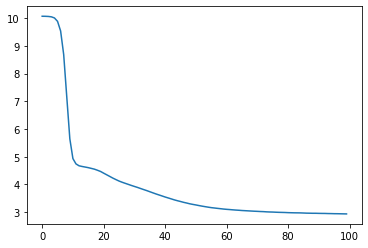

In [10]:
plot.plot(train_rmse_liste)

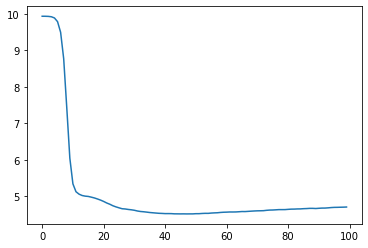

In [11]:
plot.plot(test_rmse_list)